<a href="https://colab.research.google.com/github/jonagm/Skin-Cancer-Diagnosis-with-CNN/blob/main/1_CNNThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Block 1. Connection with Google Drive**

In [ ]:
#Give access to Google Drive (access to data)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Block 2. Import libraries part 1**

In [ ]:
#Import the require libraries

import numpy as np #To be able to perform numerical operations

import torch ## Main PyTorch library for tensor computations and building neural networks
import torch.nn as nn #PyTorch's neural network module
from torch.utils.data import Dataset #It will serve as an interface for our data (Initialize and customize our dataset)
from torch.utils.data import DataLoader  #Manage data for training
from torch.nn.functional import one_hot #Convert labels to one-hot tensors
from torch import tensor #Create PyTorch tensors from existing data, such as lists or NumPy arrays.
from torch.utils.data import random_split #Function to split datasets randomly
from torch.optim.lr_scheduler import ReduceLROnPlateau #Learning rate scheduler that reduces the learning rate when a metric has stopped improving
from torchvision.transforms.functional import affine, hflip, vflip #Functions for image transformations (affine transformations, horizontal flip, vertical flip)

import os #To interact with files
from PIL import Image # Allows us to open, manipulate and show images

from pathlib import Path #Work with routes more easily

import matplotlib.pyplot as plt #To plot

from sklearn.manifold import TSNE #For dimensionality reduction and visualization of high-dimensional data
#import plotly.graph_objs as go #For creating interactive plots
import plotly.express as px #For creating easy-to-use interactive plots

#from torchvision import transforms #Lo use para la normalizacion de imagenes segun pytorch

## **Block 3. Data augmentation**

In [ ]:
class data_augment(): #Class to apply a special data augmentation
  def __init__(self, zoom_range = [0.8, 1.2], #Define the class constructor, with a specific range for some parameters
                 shear_angle = [-5, 5],
                 enable_shear = True,
                 enable_hflip = True,
                 enable_vflip = True,
                 enable_zoom = True):
        #We assign a value to the attributes of the classes
        self.zoom_range = zoom_range
        self.shear_angle = shear_angle
        self.enable_shear = enable_shear
        self.enable_hflip = enable_hflip
        self.enable_vflip = enable_vflip
        self.enable_zoom = enable_zoom

  def horizontal_flip(self, image):#Randomly decide whether to apply horizontal flip
    if np.random.uniform(0, 1) > 0.5:#If a random number between 0 and 1 is greater than 0.5, it is applied
      image = hflip(image) #Application of the function
    return image #Return the image with the transform

  def vertical_flip(self, image): #Randomly decide whether to apply vertical flip
    if np.random.uniform(0, 1) > 0.5:#random vertical flip
      image = vflip(image)
    return image

#Internal method to be used within the pending transformation methods (Zoom and Shear)
  def affine_transform(self, image, scale=1, angle=0, translate=[0, 0], shear=0): #angle and translate are not used but
    image = affine(image, scale=scale, angle=angle, translate=translate, shear=shear) #they are initialized because "affine" requires them.
    return image

  def affine_zoom(self, image):#Randomly decide whether to apply zoom
    if np.random.uniform(0, 1) > 0.5:
      zoom = np.random.uniform(*self.zoom_range)#If the condition is met, we give it a random value within a previously defined range.
      image = self.affine_transform(image, scale=zoom)#Apply the affine transform with the specific value of zoom
    return image

  def affine_shear(self, image):#Randomly decide whether to apply shear
    if np.random.uniform(0, 1) > 0.5:
      shear = np.random.uniform(*self.shear_angle)
      image = self.affine_transform(image, shear=shear)#Apply the affine transform with the specific value of shear
    return image

  def run(self, image):#Function that performs all transformations
    #if self.enable_resize:
      #image = self.transform_resize(image)

    if self.enable_hflip:
      image = self.horizontal_flip(image)#The function is applied

    if self.enable_vflip:
      image = self.vertical_flip(image)#The function is applied

    if self.enable_zoom:
      image = self.affine_zoom(image)#The function is applied

    if self.enable_shear:
      image = self.affine_shear(image)#The function is applied

    return image #Return the image with the transform

### **Sub-block 1. Creation of the class object**

In [ ]:
data_augmentation = data_augment()#An instance of the class is created to access its methods and attributes

# **Block 4. Creation of a class for our image dataset using Dataset**

In [ ]:
#Define a class for our image dataset
class CustomImageDataset(Dataset): #The class we create will inherit the "Dataset" class that was imported (a class from PyTorch).
### METHOD 1: Initializer###  clase=class
    def __init__(self, dir_data): #With "dir_data" I receive the directory where our set is
        listt = os.listdir(dir_data) #I obtained a list of the files and directories in the variable "dir_data"
        print(listt) #I printed that list (classes' carpets)
        self.input_images_path = [] #An empty list is initialized to store the image paths
        self.class_labels = np.zeros((0,1)) #(Images labels) A 0 rows,1 column matrix filled with zeros is created (This is because I will need to apply operations with NumPy later)

        #This part is required for the 3D graphics
        self.class_names = {}  # An empty dictionary is initialized to map indexes to class names
        #This part is required for the 3D graphics

        for idx, folder_path in enumerate(listt): #This creates a tuple containing the id (0,1,2,3) and the archive or element (classes'carpets) and saves it in the variables
            current_image_paths = [p for p in Path(dir_data, folder_path).iterdir() if p.suffix in {'.jpg'}]#(a list of image paths) It's a loop that iterates through a directory list,
                                                                        #with the condition that the files have a .jpg extension. Those that meet this condition will be saved to the list.
            self.input_images_path += current_image_paths #(Image routes) The obtainded paths are added
            self.class_labels = np.vstack((self.class_labels, idx * np.ones((len(current_image_paths), 1))))#(Images labeling) A 0x1 matrix is vertically stacked with a matrix of total data X1, where
                                                                                              #each element is an index. [0,0,1,1,1,2,3,0..] in vertical. [A numpy array= a matrix]

            #This part is required for the 3D graphics
            self.class_names[idx] = folder_path  #Indices are related to class names
            #This part is required for the 3D graphics

        self.num_classes = len(np.unique(self.class_labels))#Calculates the number of unique classes from the image labels: [0,1,1,2,3] ->[0,1,2,3]=4
### METHOD 2: Obtain the length of the dataset ###
    def __len__(self):
        return len(self.input_images_path)#Counts the total images routes (Total images)

### METHOD 3:Access and modify elements ###
    def __getitem__(self, idx): #Receives an "idx" to return the exact element in the dataset.
        route = self.input_images_path[idx] #Returns the path of the image with the specified "idx."
        class_labels = self.class_labels[idx] #Save the image labels

        class_labels = tensor(class_labels).long()#Convert to a tensor and change to a long data type (numpy array -> tensor)
        class_labels = one_hot(class_labels, num_classes= self.num_classes).permute(1,0)#Convert every label image into a one-hot vector of size 4x1.

        self.class_labels2 = class_labels # For TESTS (to view the one-hot vector)**

        img = Image.open(route)#Open the image using the specified path (route)
        img_resize = img.resize((224,224)) #Resize the image

        img_resize = np.array(img_resize)#Image is converted into a numpy array

        img_resize = np.moveaxis(img_resize, 2, 0)#The order of the array dimensions is changed because the image is required in the [C, H, W] format
                                                  #and PIL opens it as [H, W, C]

        img_resize = tensor(img_resize.astype(np.float32)).float()#Convert the image to a float tensor to preserve information and ensure compatibility
                                                                  #with PyTorch

        #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 #std=[0.229, 0.224, 0.225])
        #img_resize = normalize(img_resize)

        img_resize = data_augmentation.run(img_resize)#Application of data augmentation**



        return  img_resize, class_labels #returns two tensors: one containing the image and another containing the image labels in one-hot format


**Sub-block 2. Create the object with our class and split our dataset**

In [ ]:
dataset_melanoma = CustomImageDataset('/content/drive/MyDrive/DATASET 3.1/Skin cancer ISIC The International Skin Imaging Collaboration/Train')#Create an object of the class
train_dataset, val_dataset = random_split(dataset_melanoma, [0.75, 0.25]) #Split the data (.75 train and .25 val)

['squamous cell carcinoma', 'seborrheic keratosis', 'melanoma', 'nevus']


**Sub-block 3. Visualization of data length**

In [ ]:
print(train_dataset.__len__()) #verify the number of elements of train
print(val_dataset.__len__()) #verify the number of elements of val

844
281


In [ ]:
print(dataset_melanoma.class_labels) #Version of data without one-hot

[[0.]
 [0.]
 [0.]
 ...
 [3.]
 [3.]
 [3.]]


In [ ]:
dataset_melanoma[500]
data_one_hot = dataset_melanoma.class_labels2
print(data_one_hot) #Version of data with one-hot
print(data_one_hot.size())

tensor([[0],
        [0],
        [1],
        [0]])
torch.Size([4, 1])


**Sub-block 4. Display any image we want from the training set**

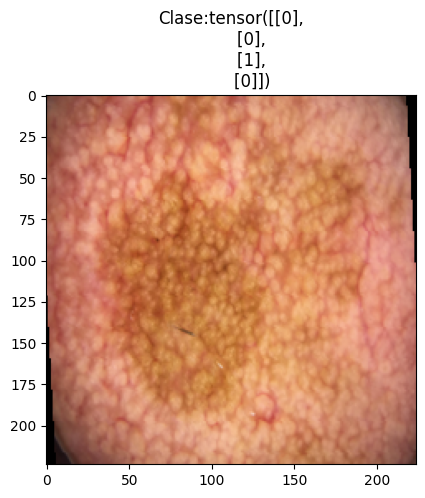

In [ ]:
img, class_label_i = train_dataset.__getitem__(253) #Save the image tensor and the label tensor
img = img.permute(1,2,0) #To use pyplot we need the format [H,W,C] not [C,H,W]
img = img / 255.0 #Normalize the image to obtain the valid range for imshow with RGB data ([0..1] for floats)
plt.imshow(img.numpy()) #Convert the tensor to numpy array to show the image (imshow requires a numpy array)
plt.title(f'Clase:{class_label_i}')
plt.show()#Show the image

## **Block 4. Extract features for 3D visualization**

---



In [ ]:
def extract_features(dataloader): #Function to extract features/parameters to plot from a dataloader
    features = [] #Empty list where the features will go
    labels = [] #Empty list where the labels will go
    for batch in dataloader: #Loop in dataloader batches
        imgs, batch_labels = batch #The batches are unpacked
        imgs = imgs.to(device)#Transfer image data to the designated compute device for optimized processing
        batch_features = imgs.reshape(imgs.size(0), -1)#The image is flattened to a one-dimensional vector to obtain its characteristics
        features.append(batch_features.cpu().numpy())#They are added to cpu because it works with a numpy array
        labels.append(batch_labels.argmax(dim=1).cpu().numpy())#They are added to cpu because it works with a numpy array and returns the index of the most probable label
    return np.concatenate(features), np.concatenate(labels)#concatenated lists of features and labels are returned

### **Sub-block 5. Creation of the dataloader to plot the training set**

In [ ]:
trainloader3d = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=2)#Creation of the dataloader to plot in 3D

## **Block 5. Plot in 3D**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Characteristics extraction
features, labels = extract_features(trainloader3d)

#T-SNE applicattion
print("Applying t-SNE...")
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)  #n_jobs=-1 to use all cores
embeddings = tsne.fit_transform(features)

# Convert numeric labels to class names
label_names = [dataset_melanoma.class_names[label[0]] for label in labels]

# Create interactive visualization with Plotly
print("Generating interactive visualization...")
fig = px.scatter_3d(
    x=embeddings[:, 0],
    y=embeddings[:, 1],
    z=embeddings[:, 2],
    color=label_names, #flatten is used because one dimension is required, and it was [841, 1]
    title='3D t-SNE visualization of the images',
    labels={'color': 'Class'},
    opacity=0.7
)

# Adjust the design
fig.update_layout(
    scene = dict(
        xaxis_title='t-SNE X',
        yaxis_title='t-SNE Y',
        zaxis_title='t-SNE Z'
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the figure
fig.show()

# **Block 6. Import libraries part 2**

In [ ]:
import torchvision #Import the library for working with datasets and pre-trained CNN models
from torch.nn import Conv2d,Linear,CrossEntropyLoss #Tools for building CNNs (layers and loss function)
import torch.optim as optim #Imports optimization algorithms for adjusting model weights
from torch.optim import Adam #Imports the Adam optimizer for efficient weight adjustment
import copy #Create deep copies of objects, often for saving model states

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay #Metrics for evaluating model performance

# **Block 7. Model creation**

## **RESNET152 (Teacher Model)**

In [ ]:
# @title
model = torchvision.models.resnet152() #Load the model without weights
#model = torchvision.models.resnet152(weights='IMAGENET1K_V1')#Load the model with weights
print(model)#For TEST (View the strcuture of the model)

n_input_channels = np.array(img).shape[2] #Obtain the number of channels of our images
n_classes = dataset_melanoma.num_classes #Obtain the number of classes from the class: dataset
#print(n_classes)#For TEST (View the number of classes)
model.conv1 = Conv2d(n_input_channels, 64, kernel_size=(7, 7), stride=(2, 2),padding=(3,3), bias=False)#Configurate the first layer of the model//no habia agregado padding ni bias
model.fc = Linear(in_features=2048, out_features= n_classes, bias=True)#Configurate the output layer of the model //no habia agregado bias

## **EfficientNetb0 (Student Model)**



In [ ]:
model = torchvision.models.efficientnet_b0() #Load the model without weights
#model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1') #Load the model with weights
print(model)#For TEST (View the strcuture of the model)

n_input_channels = np.array(img).shape[2] #Obtain the number of channels of our images
n_classes = dataset_melanoma.num_classes #Obtain the number of classes from the class: dataset
#print(n_classes)#For TEST (View the number of classes)
model.features[0][0] = Conv2d(n_input_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))#Configurate the first layer of the model
model.classifier[1] = Linear(in_features=1280, out_features= n_classes)#Configurate the output layer of the model with the correct out_features

# **Block 8. LossFunction definition**

In [ ]:
class DiceLoss(nn.Module): #Create a class for the DiceLoss
    def __init__(self): #Create an initializer method
        super(DiceLoss, self).__init__()#The constructor of the parent class (Module) is called to initialize it

    def forward(self, inputs, targets, smooth=1): #The attributes needed to execute the DiceLoss function
                                  #The inputs here are the outputs of the neural network, while the targets represent the labels
        inputs = torch.sigmoid(inputs)#(Probability) The sigmoid function is applied to the output of the neural network to obtain values between zero and one

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum() #An intersection can be represented by the sum of the element-wise multiplication
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)#Follow the formula of DICELOSS

        return 1 - dice #The result is subtracted from one to minimize the loss, as DICE equals one when vectors match

# **Block 9. Extra configurations**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'#If a GPU is available use it, otherwise use the CPU
unique_values, frequency = np.unique(train_dataset.dataset.class_labels, return_counts=True)#Obtain the unique labels values of the images and their frequency (return_counts is specific of the function)
#print(frequency)#For TEST see the frequency
#print(np.max(frequency))#For TEST see the max value
weight_ce = np.max(frequency)/frequency #Calculate the factor to balance the weights (ce=class equivalent)
criterion1 = CrossEntropyLoss(weight = torch.tensor(weight_ce, device = device) )#Define the loss function with the weights
criterion2 = DiceLoss()#Define the DICELoss
optimizer = Adam(model.parameters(),lr=0.0001)#The optimizer and the learning rate are configured
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 1/2, patience= 5)#Configure the learning rate during the training
#print(weight_ce)#For TEST see the array
#print(torch.tensor(weight_ce))#For Test

# **Block 10. LossFunction definition for the validation set**

In [ ]:
def calculate_validation_loss(model, validation_loader, criterion1,criterion2, device):#The function is created (with some input parameters)
    model.eval() #set the model in evaluation mode
    val_loss = 0 #Initialize the variable where the record of the accumulated loss in the period will be saved
    all_true_labels = [] #Empty list to which data will be added (true labels)
    all_pred_labels = [] #Empty list to which data will be added (predicted labels)

    with torch.no_grad():  #Disable gradient calculations during evaluation
        for batch in validation_loader:#Each DataLoader has batches (validation_loader=dataloader), and we iterate over those batches
            imgs, targets = batch #Getting imgs and target output for current batch

            imgs = imgs.to(device= device, dtype = torch.float32)# (Tensor) Move to the device and ensure the tensor is in the correct format
            targets = targets.to(device= device, dtype = torch.float32)# (Tensor of 4,4,1) Move to the device and ensure the tensor is in the correct format - son las etiquetas [4,4]
            #print("Targets1:",targets.size())#FOR TEST
            network_output = model(imgs) #(Predictions) Apply the model to the input images [4,4]
            #print(network_output)#FOR Test
            #output from model is [B,C], changing to [B, C, 1]
            network_output = torch.unsqueeze(network_output, dim = -1)#(Prediction) The model's output has an additional dimension added at the end of the tensor [4,4,1], which is necessary for how the data is processed
                                                                      #[4,4,1] means [[ [0.45],[458],[.69],[.698] ],...] 4 rows,4 columns, 1 value inside
            #print(network_output.size())#FOR Test
            #print("with 1:",network_output)#FOR Test (simplifica el arreglo en donde divide los valores para que salgan separeados, diferente presentacion)
            loss = criterion1(network_output, targets)+criterion2(network_output, targets) # Compute the error between the network output and target output (Tensor)

            val_loss += loss.item()#"With .item, a numerical value from a tensor is accumulated (this .item transformation only works with zero-dimensional tensors).

            #The true labels and predictions are stored
            true_label = torch.argmax(targets, dim=1).cpu().numpy()#The position of the classes (max value of tensor) for all images is selected, transferred to the CPU, and
                                                                  #converted into a NumPy array (later it will be necessary to use operations with NumPy arrays)
            pred_label = torch.argmax(network_output, dim=1).cpu().numpy() #Both (true and pred) have a size of [4,1]

            #print("size true:",true_label.shape)#FOR TEST
            #print("size pred:",pred_label.shape)#FOR TEST

            #The arrays are modified to a one dimension [n,] instead of two [n,1], necessary to work with confusion matrix
            true_label = true_label.flatten()
            pred_label = pred_label.flatten()
            #valor_prediccionT=torch.unsqueeze(valor_prediccion, dim = -1)

            #The labels are concatenated in an individual list
            all_true_labels.extend(true_label)
            all_pred_labels.extend(pred_label)

        val_loss /= len(validation_loader.dataset)#(average val loss) Outside the loop, the average loss is calculated, per example, on the validation set
                                                  #Dividing the total loss by the len of the validation data

        #Create the confusion matrix
        cm = confusion_matrix(all_true_labels, all_pred_labels)#Use the true labels and the predictions
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)#Creates the object
        disp.plot()#Prepare the figure
        plt.show()#Show the figure

        val_accuracy = accuracy_score(all_true_labels, all_pred_labels)#Calculate the accuracy on the validation set
        print(f'Val accuracy score: {val_accuracy}')#Print the accuracy
        #print("targets1.2:",targets.size())#For TEST (Here it has a size of [1,4,1] due to the final batch)
        #print("pred:",network_output.size())#FOR TEST Size of [1,4,1]
        #combined_tensor = torch.cat((targets.unsqueeze(-1), network_output.unsqueeze(-1)), dim=-1)#NOT necessary [1,4,1,1]
        combined_tensor = torch.cat((targets, network_output), dim=-1)#The true and prediction tensors are combined, where they must have the same dimension at the end
                                                                      #both have [1,4,1] the importan is the last 1
        print("Combined tensor:",combined_tensor)

        #Softmax is not used explicitly because it is already applied in the loss function

    return val_loss, val_accuracy #Return the mean loss and the accuracy

# **Block 11. CNN Training**

In [ ]:
print(f"Usando {device}")#Print whether we are using CPU or CUDA (GPU)
model.to(device)#The model is moved to the device to ensure that the processes are performed in GPU or CPU
save_dir = '/content/drive/MyDrive/Saved.M-DA-Effcientb0/pruebas'#A folder in Drive is defined to store the best training models

#An object is created for each data loader of the training and validation sets
trainloader = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=2)
valloader = DataLoader(val_dataset,batch_size=4,shuffle=True,num_workers=2)

current_minimum_loss = float('inf') #We initialize the loss to infinity to ensure that it will be updated later to save the better model

#Arrays to store values for plots
train_loss = []# An empty list to store the training loss per epoch
valid_loss = []#An empty list to store the validation loss per epoch
train_accuracy = []#An empty list to store the training accuracy per epoch
valid_accuracy=[]#An empty list to store the validation accuracy per epoch

#TRAINING
for epoch in range(3): #A loop that iterates over all the data (epochs)
    model.train() #Switch to training mode to calculate gradients = backpropagation = derivatives

    #Initialization of attributes for metrics
    #*This is for the printed train loss
    running_loss = 0.0 #This variable is initialized to store the accumulated loss per epoch

    #*This will help us to update the current loss:
    total_train_loss = 0.0 #An attribute is initialized to hold the total loss during training
    total_train_batches =0 #An attribute is initialized to hold the total number of batches used in training

    #print(epoch)#FOR TEST
    for i, data in enumerate(trainloader): #It iterates over each data batch and stores a tuple (indices=batch and the corresponding value/image with label)
      #print(f"Batch {i+1}/{len(trainloader)}")#FOR TESTS (Check which batch is currently being processed out of the total)
      inputs, labels = data #Extract the input data/images and the labels from the current batch in the variable data

      #The tensors are moved to the device and their type is defined
      inputs = inputs.to(device= device, dtype=torch.float32) #Images
      labels = labels.to(device=device, dtype=torch.float32) #Labels

      # Before the gradients are calculated, all the gradients of the model parameters are set to zero (with a method of ADAM)
      optimizer.zero_grad() #This is done because in PyTorch, gradients are accumulated

      # Forward + Backward + Optimizer
      outputs = model(inputs) #(Predictions= Forward pass) Apply the model to the input images [4,4]
      outputs = torch.unsqueeze(outputs, dim = -1)#The model's output has an additional dimension added at the end of the tensor [4,4,1], which is necessary for how the data is processed
                                                  #[4,4,1] means [[ [0.45],[458],[.69],[.698] ],...] 4 rows,4 columns, 1 value inside

      loss =criterion1(outputs, labels)+criterion2(outputs, labels)# The loss is calculated between the model's predictions (outputs) and the actual labels (labels) using both
                                                                  #loss functions
      loss.backward() #The gradients of the loss function are calculated (determining how the weights should be adjusted to reduce the loss)
      optimizer.step() #The model parameters are updated using ADAM to reduce the loss

      #Accumulated loss
      running_loss += loss.item() #The current loss is accumulated
      total_train_loss += loss.item() #With .item, a numerical value from a tensor is accumulated
      total_train_batches += 1 #Increment the batch count by 1 per data

      #Metrics calculus
      if outputs.dim() == 3: #If we have [0,1,2] dimensions to predictions
        outputs = outputs.squeeze(dim=-1)#A dimension is removed for calculation
      if labels.dim() == 3: #por que se requieren 2 dimensiones en lugar de 3
        labels = labels.squeeze(dim=-1)

      predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy() #The position of the classes (max value of tensor) for all images is selected, transferred to the CPU, and
                                                                    #converted into a NumPy array (later it will be necessary to use operations with NumPy arrays)
      true_labels = torch.argmax(labels, dim=1).cpu().numpy()
      train_accuracy2 = accuracy_score(predicted_labels,true_labels) #Calculate the accuracy on the training set

      #FOR TEST: Print the arrays to verify that they are correct and consistent
      #print(f"Predicted labels: {predicted_labels}")
      #print(f"True labels: {true_labels}")

      if i % 10 == 0: #Check if the batch index is a multiple of 10 to print the average loss
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')#The average loss is printed every 10 mini-batches
        running_loss = 0.0 #The running_loss is reset to zero after printing the average loss

    validation_loss, validation_accuracy = calculate_validation_loss(model,valloader,criterion1,criterion2,device) #The validation loss method is used to obtain the loss and accuracy
                                                                                                                  #from the validation set, and store them in variables within this loop
    lr_scheduler.step(validation_loss) #The learning rate is updated based on the loss in the validation set

    #Mean loss and accuracy append of traininig
    avg_train_loss = total_train_loss / total_train_batches #The mean training loss is obtained
    train_loss.append(avg_train_loss) #The mean values are added to the 'train_loss' list
    train_accuracy.append(train_accuracy2) #The results of accuracy of training are added to the initial list

    #Loss and accuracy append of validation
    valid_loss.append(validation_loss)
    valid_accuracy.append(validation_accuracy)

    if validation_loss < current_minimum_loss:# If the validation loss is lower than the current loss, the model is saved using 'state dict,' along with the loss and the epoch
      best_model_state_dict, current_minimum_loss, best_epoch = copy.deepcopy(model.state_dict()), validation_loss, epoch #that achieved the best performance


    print(f"Epoch ={epoch} finished. Loss value in validation dataset = {validation_loss} --- Value LR ={optimizer.param_groups[0]['lr']  } ")
print('Finished Training ')
print(f"Best model epoch = {best_epoch} with current loss = {current_minimum_loss}")
torch.save(best_model_state_dict, os.path.join(save_dir, f"Model_epoch_{best_epoch}_val_loss_{validation_loss}.pth"))#

#Display graphs of loss and accuracy
plt.figure(figsize=(12, 5))

#Loss graphic
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#Accuracy graphic
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Verificar datos se impriman bien
print((train_loss))
print((valid_loss))
print(train_accuracy)
print(valid_accuracy)

# **Knowledge Dsitillation/Model Distillation Implemetntation**

### **Sub-block 6. Import libraries part.3**

In [ ]:
from collections import OrderedDict #Maintains the order of elements as they are added

## **Block 12. Define teacher model: RESNET152**

In [ ]:
def load_teacher_model(model_path, device = 'cuda' if torch.cuda.is_available() else 'cpu'): #define the method that loads the teacher model (the folder and the device where it will be loaded)
    # Load the model (learned parameters) into the 'state_dict'
    state_dict = torch.load(model_path) #Learned parameters

    # Determines the number of input channels and output classes
    n_channels_input = state_dict[list(state_dict.keys())[0]].size(1) #Is the first tensor and '.size(1)' return the channels of the tensor, which are in the second position
    n_classes = state_dict[list(state_dict.keys())[-1]].size(0)# Is the last the last tensor and size(0)return the classes, wich are in the first position

    #The teacher model is loaded RESNET152
    teacher_model = torchvision.models.resnet152()

    #Adjust the first convolutional layer to the number of input channels
    teacher_model.conv1 = Conv2d(n_channels_input, 64, kernel_size=(7, 7), stride=(2, 2))

    #Adjust the fully connected layer to the number of output classes
    teacher_model.fc = Linear(in_features=2048, out_features= n_classes)

    #Move the model to the appropriate device (CPU or GPU)
    teacher_model.to(device= device)

    #The 'state_dict' attribute, which contains the parameters of the previously trained model (the saved model), is loaded into the instance of the loaded model architecture
    try:
        teacher_model.load_state_dict(state_dict) #In teacher_model, the state_dict is loaded
    except:
      #If there is a module. prefix, we remove it
        new_state_dict = OrderedDict() #It is sorted
        for k, v in state_dict.items(): #The names and values are stored
            name = k[10:] # remove `module.`
            new_state_dict[name] = v
      # load params
        teacher_model.load_state_dict(new_state_dict)

    return teacher_model

## **Block 13. Define the Student model: EfficientNetb0**

In [ ]:
def load_stud_model(model_path, device = 'cuda' if torch.cuda.is_available() else 'cpu'): #define the method that loads the student model (the folder and the device where it will be loaded)
    #Load the model (learned parameters) into the 'state_dict'
    state_dict = torch.load(model_path)

    #Determines the number of input channels and output classes
    n_channels_input = state_dict[list(state_dict.keys())[0]].size(1) #Is the first tensor and '.size(1)' return the channels of the tensor, which are in the second position
    n_classes = state_dict[list(state_dict.keys())[-1]].size(0) #Is the last the last tensor and size(0)return the classes, wich are in the first position

    #The student model is loaded: EfficientNetb0
    student_model = torchvision.models.efficientnet_b0()

    #Adjust the first layer to the number of input channels
    student_model.features[0][0] = Conv2d(n_channels_input, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    #Adjust the last layer to the number of output classes
    student_model.classifier[1] = Linear(in_features=1280, out_features= n_classes)

    #Move the model to the appropriate device (CPU or GPU)
    student_model.to(device= device)

    #The 'state_dict' attribute, which contains the parameters of the previously trained model (the saved model), is loaded into the instance of the loaded model architecture
    try:
        student_model.load_state_dict(state_dict) #In student_model, the state_dict is loaded
    except:
    #If there is a module. prefix, we remove it
        new_state_dict = OrderedDict() #It is sorted
        for k, v in state_dict.items():
            name = k[10:] # remove `module.`
            new_state_dict[name] = v
        # load params
        student_model.load_state_dict(new_state_dict)

    return student_model

### **Sub-block 6. Load the pre-trained models**

In [ ]:
teacher = load_teacher_model('/content/drive/MyDrive/S.M.RESNET152SinWeights-D3.1-D.A/Modelo_epoch_28_val_loss_0.49938366342045887.pth')
student = load_stud_model('/content/drive/MyDrive/Saved.M-DA-Effcientb0/30epocas-D3.1-D.A/Modelo_epoch_26_val_loss_0.40930686070512023.pth')
#student = load_stud_model('/content/drive/MyDrive/S.M-MobileV2SinWeights-D3.1-D.A/30epocas/Modelo_epoch_20_val_loss_0.4078884457101193.pth')

## **Block 14. Model distillation training**

In [ ]:
def train_model_distillation(teacher,student,optimizer,criterion1,criterion2,epochs,device, save_dir,temperature=2):
    print(f"Usando {device}")
    student.to(device)

    #An object is created for each data loader of the training and validation sets
    trainloader = DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=2,drop_last=False)
    valloader = DataLoader(val_dataset,batch_size=4,shuffle=True,num_workers=2, drop_last=False)

    current_minimum_loss = float('inf') #We initialize the loss to infinity to ensure that it will be updated later to save the better model

    #Arrays to store values for plots
    train_loss = [] #An empty list to store the training loss per epoch
    valid_loss = [] #An empty list to store the validation loss per epoch
    train_accuracy = [] #An empty list to store the training accuracy per epoch
    valid_accuracy=[] #An empty list to store the validation accuracy per epoch

    student.train() #Set the student model to training mode
    teacher.eval() #Set the master model to evaluation mode

    #TRAINING
    for epoch in range(epochs):  #A loop that iterates over all the data (epochs)
        #Initialization of attributes for metrics
        #*This is for the printed train loss
        running_loss = 0.0 #This variable is initialized to store the accumulated loss per epoch

        #*This will help us to update the current loss:
        total_loss = 0.0 #An attribute is initialized to hold the total loss during training
        total_batches =0 #An attribute is initialized to hold the total number of batches used in training
        #print(epoch)#FOR TEST
        for i, data in enumerate(trainloader): #It iterates over each data batch and stores a tuple (index=batch and the corresponding value/image with label)
            #print(f"Batch {i+1}/{len(trainloader)}") #FOR TESTS (Check which batch is currently being processed out of the total)
            inputs, labels = data #Extract the input data/images and the labels from the current batch in the variable data

            #The tensors are moved to the device and their type is defined
            inputs = inputs.to(device= device, dtype=torch.float32) #Images
            labels = labels.to(device=device, dtype=torch.float32) #Labels
      #++++++++++++++++++++++++++++++#
            labels = labels.squeeze(dim=-1) #+One dimension is removed from the labels to match the required format
      #++++++++++++++++++++++++++++++#

      # Before the gradients are calculated, all the gradients of the model parameters are set to zero (with a method of ADAM)
            optimizer.zero_grad() #This is done because in PyTorch, gradients are accumulated

      #++++++++++++++++++++++++++++++++++++++#
            with torch.no_grad(): #Disable gradient calculations during evaluation
                teacher_logits = teacher(inputs) #Forward propagation with teacher (predictions) is performed, but gradients are not updated
            student_logits = student(inputs) #Forward propagation with student, gradients are updated
      #MODEL DISTILLATION
      #Arbitrary weights are defined, where alpha should be significantly larger in scale than 1
            alpha = 0.7
            beta = 0.3

            soft_targets_teacher = torch.softmax(teacher_logits / temperature, dim=-1)
            soft_targets_student = torch.log_softmax(student_logits / temperature, dim=-1)

            #LET'S CALCULATE THE LOSS OF the soft_targets
            soft_targets_loss = torch.sum(soft_targets_teacher * (soft_targets_teacher.log() - soft_targets_student)) / soft_targets_student.size()[0] * (temperature**2) #Esta es la primer funcion objetivo

            label_loss = criterion1(student_logits, labels) #This is the second objective function that accepts the unnormalized logits and a tensor

            loss = alpha*soft_targets_loss + beta*label_loss #The loss is calculated between the model's predictions (outputs) and the true labels (labels)
      #+++++++++++++++++++++++++++++++++++++

            loss.backward() #The gradients of the loss function are calculated (determining how the weights should be adjusted to reduce the loss)
            optimizer.step() #The model parameters are updated using ADAM to reduce the loss

      #Accumulated loss
            running_loss += loss.item() #The current loss is accumulated
            total_loss += loss.item() #With .item, a numerical value from a tensor is accumulated
            total_batches += 1 #Increment the batch count by 1 per data

      #Metrics calculus
            if student_logits.dim() == 3: #If we have [0,1,2] dimensions to predictions
              student_logits = student_logits.squeeze(dim=-1) #A dimension is removed for calculation
            if labels.dim() == 3: #This is because 2 dimensions are required instead of 3
              labels = labels.squeeze(dim=-1)

            predicted_labels = torch.argmax(student_logits, dim=1).cpu().numpy() #The position of the classes (max value of tensor) for all images is selected, transferred to the CPU, and
                                                                                  ##converted into a NumPy array (later it will be necessary to use operations with NumPy arrays)
            true_labels = torch.argmax(labels, dim=1).cpu().numpy()#Nos devuelve los índices de las clases
            train_accuracy2 = accuracy_score(predicted_labels,true_labels)#Calculate the accuracy on the training set

      #FOR TEST: Print the arrays to verify that they are correct and consistent
      #print(f"Predicted labels: {predicted_labels}")
      #print(f"True labels: {true_labels}")

            if i % 10 == 0: #Check if the batch index is a multiple of 10 to print the average loss
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')#The average loss is printed every 10 mini-batches
              running_loss = 0.0 #The running_loss is reset to zero after printing the average loss

        validation_loss, validation_accuracy = calculate_validation_loss(student,valloader,criterion1,criterion2,device) #The validation loss method is used to obtain the loss and accuracy
                                                                                                                         #from the validation set, and store them in variables within this loop
        lr_scheduler.step(validation_loss) #The learning rate is updated based on the loss in the validation set

        ##Mean loss and accuracy append of traininig
        avg_train_loss = total_loss / total_batches #The mean training loss is obtained
        train_loss.append(avg_train_loss) #The mean values are added to the 'train_loss' list
        train_accuracy.append(train_accuracy2) #The results of accuracy of training are added to the initial list

        #Loss and accuracy append of validation
        valid_loss.append(validation_loss)
        valid_accuracy.append(validation_accuracy)

        if validation_loss < current_minimum_loss: ## If the validation loss is lower than the current loss, the model is saved using 'state dict,' along with the loss and the epoch
          best_model_state_dict, current_minimum_loss, best_epoch = copy.deepcopy(student.state_dict()), validation_loss, epoch #that achieved the best performance


        print(f"Epoca ={epoch} terminada. Valor de perdida en conjunto de validacion = {validation_loss} --- valor LR ={optimizer.param_groups[0]['lr']  } ")
    print('Finished Training ')
    print(f"Best model epoch = {best_epoch} with current loss = {current_minimum_loss}")#
    torch.save(best_model_state_dict, os.path.join(save_dir, f"Modelo_epoch_{best_epoch}_val_loss_{validaion_loss}.pth"))#

    #Display graphs of loss and accuracy
    plt.figure(figsize=(12, 5))

    #Loss graphic
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    #Accuracy graphic
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### **Sub-block 7. Application of the method**

In [ ]:
train_model_distillation(teacher, student, optimizer, criterion1, criterion2, epochs=1, device=device, save_dir='/content/drive/MyDrive/S.M-ModelDistillationD3.1/Res152-Res50')